## 1. Load Raw Data

Load the raw dataset to understand its initial structure and volume.


In [11]:
import os
import pandas as pd
import seaborn as sns
from IPython.display import display

import matplotlib.pyplot as plt


RAW_DATA_PATH = "../data/raw/complaints.csv" 
PROCESSED_DATA_PATH = "data/processed/filtered_complaints.csv"
if os.path.exists(RAW_DATA_PATH):
    df_raw = pd.read_csv(RAW_DATA_PATH)
    print(f"Raw data loaded. Shape: {df_raw.shape}")
    display(df_raw.head(3))
else:
    print(f"Raw data not found at {RAW_DATA_PATH}. Please ensure the file exists.")
    df_raw = pd.DataFrame()


/tmp/ipykernel_46719/881905556.py:12: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(RAW_DATA_PATH)


Raw data loaded. Shape: (9609797, 18)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,FL,32092,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195687
1,2025-06-20,Debt collection,Telecommunications debt,Attempts to collect debt not owed,Debt is not yours,NaN,Company can't verify or dispute the facts in t...,"Eastern Account Systems of Connecticut, Inc.",FL,342XX,NaN,NaN,Web,2025-06-20,Closed with explanation,Yes,NaN,14195688
2,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195689


## 2. Quantify Missing Narratives

A critical step is identifying how many complaints actually contain a narrative text, as this is the core input for our RAG system.


Total Complaints: 9609797
Missing Narratives: 6629041 (69.0%)
Usable Narratives: 2980756 (31.0%)


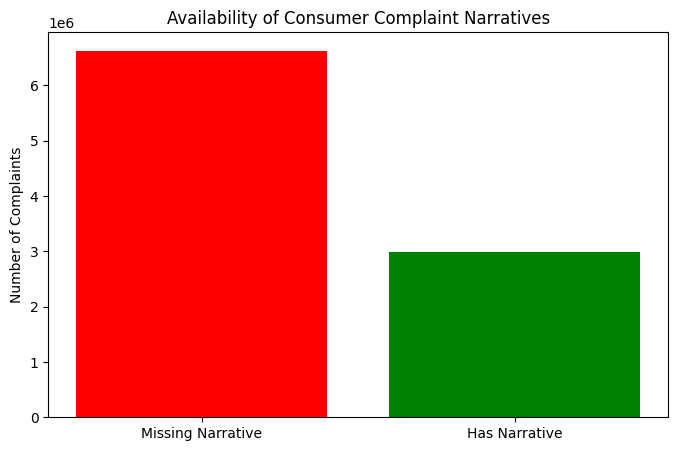

In [12]:
if not df_raw.empty:
    total_complaints = len(df_raw)
    missing_narratives = df_raw['Consumer complaint narrative'].isna().sum()
    present_narratives = total_complaints - missing_narratives
    
    print(f"Total Complaints: {total_complaints}")
    print(f"Missing Narratives: {missing_narratives} ({missing_narratives/total_complaints:.1%})")
    print(f"Usable Narratives: {present_narratives} ({present_narratives/total_complaints:.1%})")
    
    # Visualization
    plt.figure(figsize=(8, 5))
    plt.bar(['Missing Narrative', 'Has Narrative'], [missing_narratives, present_narratives], color=['red', 'green'])
    plt.title("Availability of Consumer Complaint Narratives")
    plt.ylabel("Number of Complaints")
    plt.show()


## 3. Define Preprocessing Functions

We define the logic to filter for the four target products and clean the text.
Target Products:
1. Credit card
2. Personal loan
3. Savings account
4. Money transfers


In [13]:
def clean_text(text):
    """Cleans the text narrative."""
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = text.replace("xxxx", "") # Remove redaction placeholders
    text = " ".join(text.split()) # Normalize whitespace
    return text

def process_complaints(df):
    """Filters and cleans the complaint dataset."""
    # Product Mapping
    product_map = {
        "Credit card": "Credit card",
        "Credit card or prepaid card": "Credit card",
        "Prepaid card": "Credit card",
        "Payday loan, title loan, or personal loan": "Personal loan",
        "Personal loan": "Personal loan",
        "Checking or savings account": "Savings account",
        "Savings account": "Savings account",
        "Money transfer, virtual currency, or money service": "Money transfers",
        "Money transfers": "Money transfers"
    }
    
    # Create normalized product column
    df['normalized_product'] = df['Product'].map(product_map)
    
    # Filter for target products (drop rows where map returned NaN)
    df_filtered = df.dropna(subset=['normalized_product']).copy()
    
    # Filter for non-empty narratives
    df_filtered = df_filtered.dropna(subset=['Consumer complaint narrative'])
    
    # Clean narratives
    df_filtered['cleaned_narrative'] = df_filtered['Consumer complaint narrative'].apply(clean_text)
    
    return df_filtered


## 4. Apply Filtering and Preprocessing

Apply the transformation to the raw data.


In [14]:
if not df_raw.empty:
    df_processed = process_complaints(df_raw)
    print(f"Processed Data Shape: {df_processed.shape}")
    display(df_processed.head(3))
else:
    df_processed = pd.DataFrame()


Processed Data Shape: (453368, 20)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,normalized_product,cleaned_narrative
12237,2025-06-13,Credit card,Store credit card,Getting a credit card,Card opened without my consent or knowledge,A XXXX XXXX card was opened under my name by a...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",TX,78230,Servicemember,Consent provided,Web,2025-06-13,Closed with non-monetary relief,Yes,NaN,14069121,Credit card,a card was opened under my name by a fraudster...
12532,2025-06-13,Checking or savings account,Checking account,Managing an account,Deposits and withdrawals,I made the mistake of using my wellsfargo debi...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,ID,83815,NaN,Consent provided,Web,2025-06-13,Closed with explanation,Yes,NaN,14061897,Savings account,i made the mistake of using my wellsfargo debi...
13280,2025-06-12,Credit card,General-purpose credit card or charge card,"Other features, terms, or problems",Other problem,"Dear CFPB, I have a secured credit card with c...",Company has responded to the consumer and the ...,"CITIBANK, N.A.",NY,11220,NaN,Consent provided,Web,2025-06-13,Closed with monetary relief,Yes,NaN,14047085,Credit card,"dear cfpb, i have a secured credit card with c..."


## 5. Visualize Target Product Distribution

Analyze the distribution of complaints across the four specific product categories in the final dataset.


/tmp/ipykernel_46719/78902573.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=product_counts.index, y=product_counts.values, palette="viridis")


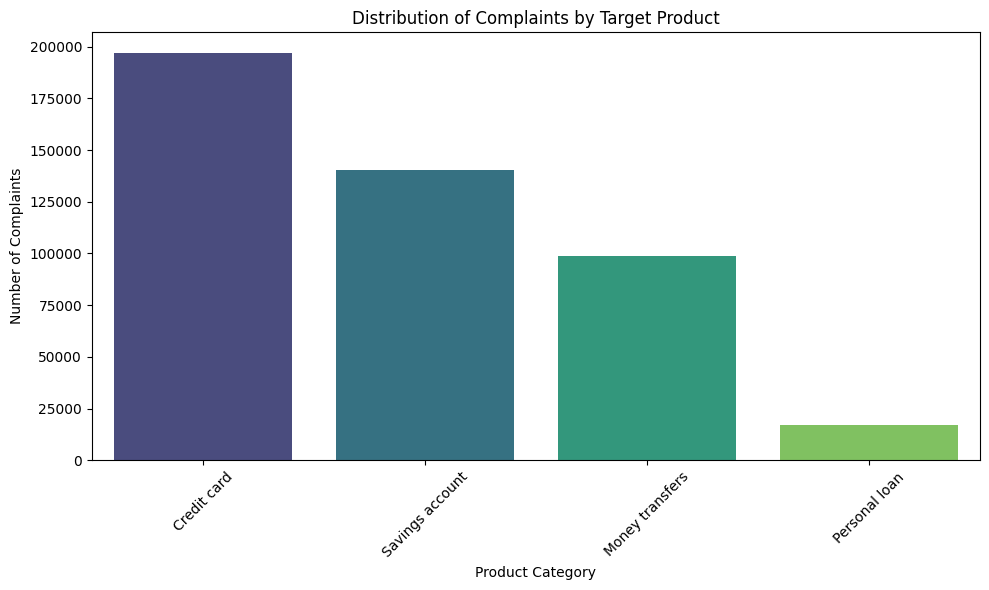

normalized_product
Credit card        197126
Savings account    140319
Money transfers     98685
Personal loan       17238
Name: count, dtype: int64


In [15]:
if not df_processed.empty:
    product_counts = df_processed['normalized_product'].value_counts()
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=product_counts.index, y=product_counts.values, palette="viridis")
    plt.title("Distribution of Complaints by Target Product")
    plt.xlabel("Product Category")
    plt.ylabel("Number of Complaints")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print(product_counts)


## 6. Analyze Narrative Length Distributions

Analyze the length of the complaints to understand the input size for our embedding model.


Narrative Length Statistics:
count    453368.000000
mean        198.455310
std         219.018151
min           0.000000
25%          80.000000
50%         132.000000
75%         246.000000
max        6263.000000
Name: word_count, dtype: float64


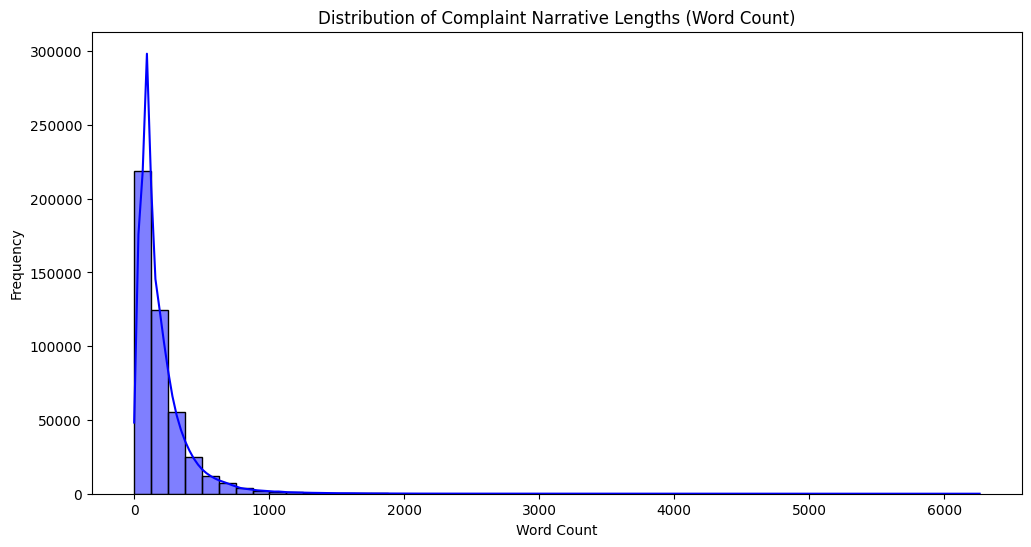

In [16]:
if not df_processed.empty:
    # Calculate word count
    df_processed['word_count'] = df_processed['cleaned_narrative'].apply(lambda x: len(x.split()))
    
    print("Narrative Length Statistics:")
    print(df_processed['word_count'].describe())
    
    plt.figure(figsize=(12, 6))
    sns.histplot(df_processed['word_count'], bins=50, kde=True, color='blue')
    plt.title("Distribution of Complaint Narrative Lengths (Word Count)")
    plt.xlabel("Word Count")
    plt.ylabel("Frequency")
    plt.show()


## 7. Export Processed Data

Save the final cleaned dataset to the specified path.


In [17]:
if not df_processed.empty:
    os.makedirs(os.path.dirname(PROCESSED_DATA_PATH), exist_ok=True)
    df_processed.to_csv(PROCESSED_DATA_PATH, index=False)
    print(f"Successfully saved processed data to {PROCESSED_DATA_PATH}")


Successfully saved processed data to data/processed/filtered_complaints.csv
